In [1]:
from collections import defaultdict
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from irls.irls import LogisticRegression

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler

In [2]:
ONLINE = False
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data" if ONLINE else os.path.join('data', 'adult.data')

In [3]:
adult_df = pd.read_csv(url, header=None)
adult_df.columns = ['age',
                    'workclass',
                    'fnlwgt',
                    'education',
                    'education-num',
                    'marital-status',
                    'occupation',
                    'relationship',
                    'race',
                    'sex',
                    'capital-gain',
                    'capital-loss',
                    'hours-per-week',
                    'native-country',
                    'target']
adult_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
x_adult = adult_df.drop(['target'], axis=1)
y_adult = adult_df['target']
categorical_features = ['workclass',
                        'education',
                        'marital-status',
                        'occupation',
                        'relationship',
                        'race',
                        'sex',
                        'native-country']
numerical_features = list(set(x_adult.columns).difference(set(categorical_features)))
categorical_transformer = Pipeline([('ohe', OneHotEncoder(sparse_output=False,
                                                          drop='first',
                                                          min_frequency=0.05,
                                                          handle_unknown='infrequent_if_exist'))])
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", FunctionTransformer(lambda x: x), numerical_features)
    ]
)
y_adult = LabelEncoder().fit_transform(y_adult)

In [6]:
pd.Series(y_adult).value_counts(normalize=True)

0    0.75919
1    0.24081
dtype: float64

In [7]:
x_adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


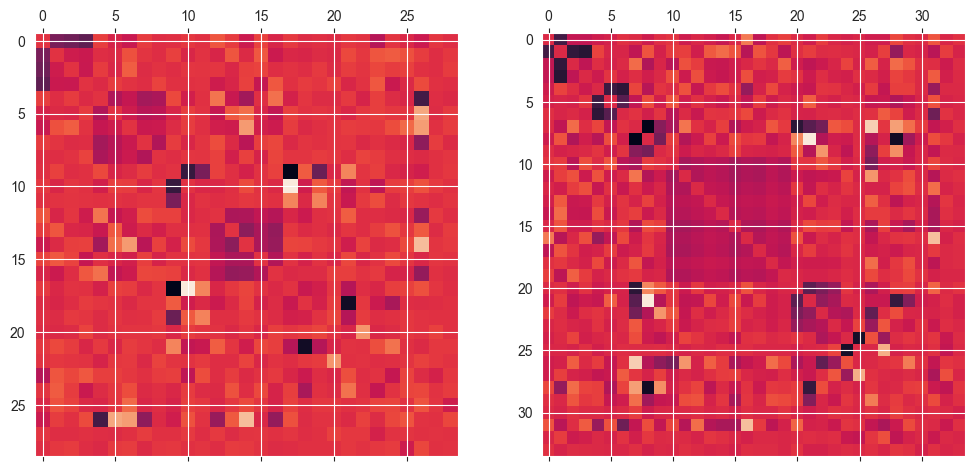

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
corr_mat_1 = pd.DataFrame(preprocessor.fit_transform(x_adult[y_adult==1])).corr()
corr_mat_0 = pd.DataFrame(preprocessor.fit_transform(x_adult[y_adult==0])).corr()
ax[0].matshow(corr_mat_1 - np.identity(len(corr_mat_1)))
ax[1].matshow(corr_mat_0 - np.identity(len(corr_mat_0)))

In [9]:
1 - np.abs(corr_mat_0)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.000000,0.598548,0.929023,0.924243,0.959382,0.976567,0.982978,0.997695,0.958536,0.987085,...,0.975523,0.991794,0.962066,0.963197,0.929526,0.981597,0.994655,0.898053,0.991487,0.978881
1,0.598548,0.000000,0.551278,0.521060,0.938193,0.986460,0.985314,0.918053,0.900219,0.973497,...,0.994284,0.995513,0.973243,0.946300,0.810195,0.995096,0.981318,0.902705,0.948276,0.983585
2,0.929023,0.551278,0.000000,0.915323,0.987621,0.980017,0.996170,0.847260,0.876823,0.985268,...,0.937181,0.985066,0.876559,0.981673,0.847216,0.893059,0.978931,0.988115,0.953261,0.991401
3,0.924243,0.521060,0.915323,0.000000,0.953278,0.968470,0.974344,0.985903,0.965783,0.998139,...,0.968312,0.983754,0.995765,0.970214,0.937793,0.963811,0.996631,0.883295,0.969912,0.995455
4,0.959382,0.938193,0.987621,0.953278,0.000000,0.582578,0.538352,0.932336,0.897784,0.968485,...,0.993515,0.968634,0.954828,0.928647,0.944561,0.946325,0.996034,0.817973,0.999571,0.998801
5,0.976567,0.986460,0.980017,0.968470,0.582578,0.000000,0.652979,0.922915,0.914076,0.965224,...,0.997852,0.993730,0.938067,0.943049,0.879938,0.936794,0.986584,0.906889,0.983680,0.996498
6,0.982978,0.985314,0.996170,0.974344,0.538352,0.652979,0.000000,0.972729,0.968663,0.969898,...,0.994420,0.989052,0.977506,0.880665,0.934680,0.962617,0.995627,0.710320,0.975298,0.996065
7,0.997695,0.918053,0.847260,0.985903,0.932336,0.922915,0.972729,0.000000,0.405367,0.774579,...,0.914431,0.993545,0.593499,0.966825,0.721302,0.837851,0.948035,0.927724,0.970057,0.982937
8,0.958536,0.900219,0.876823,0.965783,0.897784,0.914076,0.968663,0.405367,0.000000,0.734051,...,0.954095,0.991627,0.891016,0.984019,0.455283,0.838902,0.956778,0.916200,0.960667,0.980110
9,0.987085,0.973497,0.985268,0.998139,0.968485,0.965224,0.969898,0.774579,0.734051,0.000000,...,0.916878,0.985841,0.793785,0.944079,0.763570,0.932633,0.993478,0.924857,0.994564,0.999253


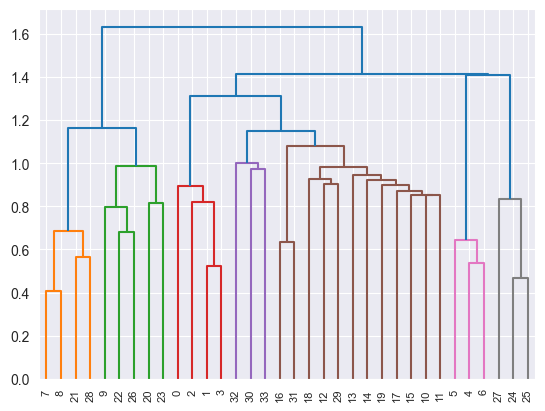

In [10]:
distance_matrix = 1 - np.abs(corr_mat_0)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.show()

In [11]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1.1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [12]:
selected_features

[0, 4, 7, 9, 10, 24, 30]

## Modelling

In [13]:
models = {
    'QDA': QuadraticDiscriminantAnalysis(tol=1.0e-16),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('knn_clf', KNeighborsClassifier())
    ]),
    'Logistic': LogisticRegression(),
}
results_full = []
for name, model in models.items():
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    for i, (train_idx, test_idx) in enumerate(skf.split(x_adult, y_adult)):
        pipe = Pipeline([('preprocess', preprocessor),
                         ('clf', model)])
        pipe = pipe.fit(x_adult.loc[train_idx], y_adult[train_idx])
        y_hat = pipe.predict(x_adult.loc[test_idx])
        results_full += [{
            'model': name,
            'i': i,
            'accuracy': accuracy_score(y_hat, y_adult[test_idx]),
            'balanced_accuracy': balanced_accuracy_score(y_hat, y_adult[test_idx]),
            'f1': f1_score(y_hat, y_adult[test_idx]),
            'n_features': preprocessor.fit_transform(x_adult.loc[train_idx]).shape[1]
        }]

results_full = pd.DataFrame(results_full)

E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These u

Text(0.5, 1.0, 'F1 score')

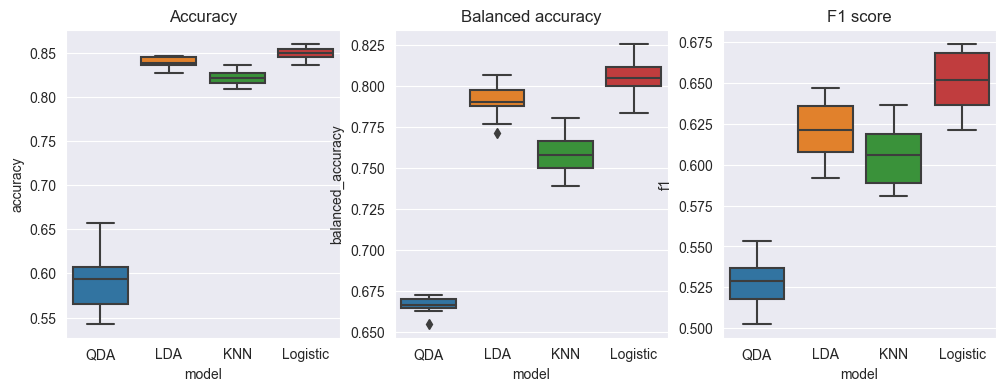

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.boxplot(results_full, x='model', y='accuracy', ax=ax[0])
sns.boxplot(results_full, x='model', y='balanced_accuracy', ax=ax[1])
sns.boxplot(results_full, x='model', y='f1', ax=ax[2])
ax[0].set_title("Accuracy")
ax[1].set_title("Balanced accuracy")
ax[2].set_title("F1 score")

## Feature selection - removing collinear variables

Source: [https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features)

In [15]:
def select_features(x, threshhold):
    corr_mat = pd.DataFrame(x).corr()
    distance_matrix = 1 - np.abs(corr_mat)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    cluster_ids = hierarchy.fcluster(dist_linkage, threshhold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return x[:, selected_features], selected_features

In [16]:
select_features(preprocessor.fit_transform(x_adult), 0.8)

(array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.17400e+03,
         7.75160e+04, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
         8.33110e+04, 0.00000e+00],
        [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         2.15646e+05, 0.00000e+00],
        ...,
        [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         1.51910e+05, 0.00000e+00],
        [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         2.01490e+05, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.50240e+04,
         2.87927e+05, 0.00000e+00]]),
 [0,
  1,
  2,
  4,
  5,
  8,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  18,
  20,
  22,
  23,
  26,
  28,
  29,
  31,
  32])

In [17]:
results_select = []
# thresholds for feature selection
thresholds = [0, 0.2, 0.5, 0.7, 0.85, 1.0, 1.25, 1.5]

for t in thresholds:
    for name, model in models.items():
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
        for i, (train_idx, test_idx) in enumerate(skf.split(x_adult, y_adult)):
            train_prep = preprocessor.fit_transform(x_adult.loc[train_idx])
            x_selected, features = select_features(train_prep, t)
            model = model.fit(x_selected, y_adult[train_idx])
            y_hat = model.predict(preprocessor.transform(x_adult.loc[test_idx])[:,features])
            results_select += [{
                'model': name,
                'i': i,
                'accuracy': accuracy_score(y_hat, y_adult[test_idx]),
                'balanced_accuracy': balanced_accuracy_score(y_hat, y_adult[test_idx]),
                'f1': f1_score(y_hat, y_adult[test_idx]),
                'threshold': t,
                'n_features': len(features)
            }]

results_select = pd.DataFrame(results_select)

E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These u

Text(0.5, 1.0, 'Number of selected features')

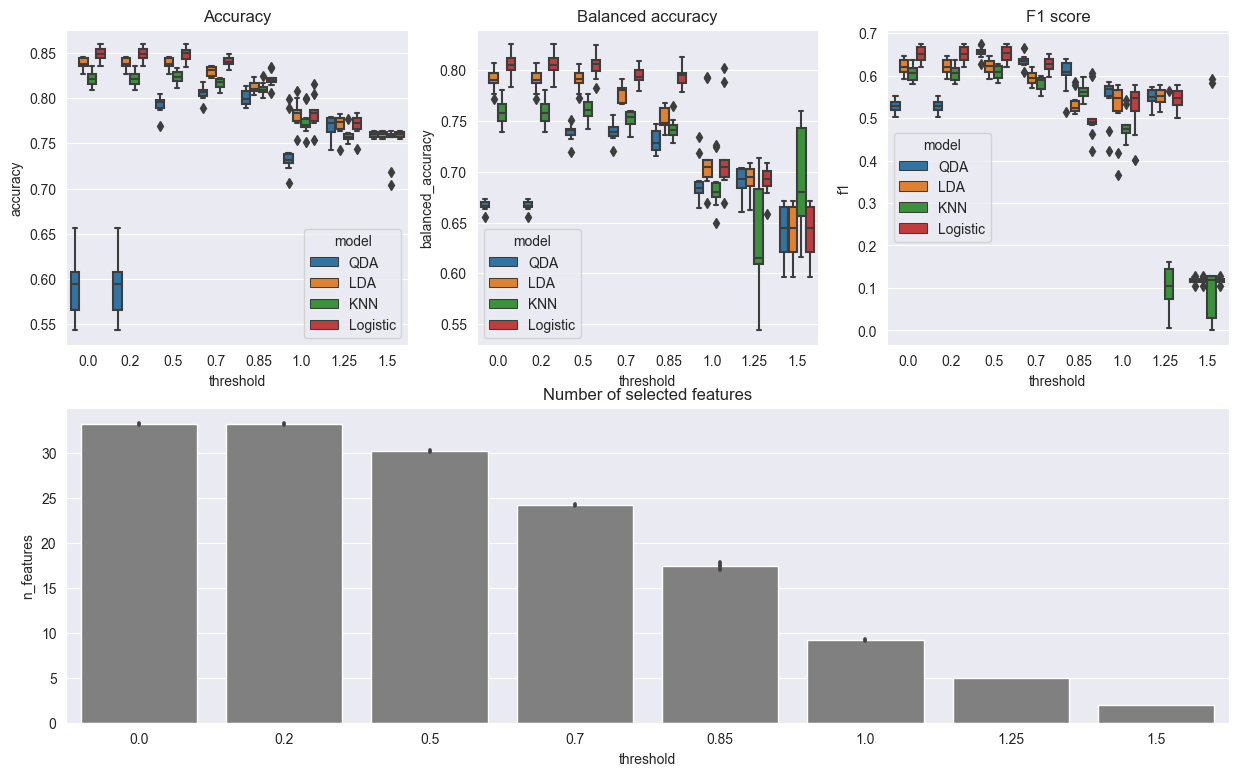

In [18]:
fig = plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(2, 3, (4, 6))

sns.boxplot(results_select, x='threshold', y='accuracy', hue='model', ax=ax1)
ax1.set_title("Accuracy")
sns.boxplot(results_select, x='threshold', y='balanced_accuracy', hue='model', ax=ax2)
ax2.set_title("Balanced accuracy")

sns.boxplot(results_select, x='threshold', y='f1', hue='model', ax=ax3)
ax3.set_title("F1 score")

sns.barplot(results_select, x='threshold', y='n_features', color='gray', ax=ax4)
ax4.set_title("Number of selected features")

## Logistic Regression with interactions

After one hot encoding we obtain over 30 features, thus we will consider interactions only between the numerical features.

In [46]:
idx = [x for x in range(28,33)]
inter = pd.DataFrame(list(itertools.combinations(idx, 2)))
results_inter = []


preprocessor_scaler = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
for i, (train_idx, test_idx) in enumerate(skf.split(x_adult, y_adult)):
    train_prep = preprocessor_scaler.fit_transform(x_adult.loc[train_idx])
    model = LogisticRegression().fit(train_prep, y_adult[train_idx], interactions=inter)
    y_hat = model.predict(preprocessor_scaler.transform(x_adult.loc[test_idx]))
    results_inter += [{
        'model': "Logistic_inter",
        'accuracy': accuracy_score(y_hat, y_adult[test_idx]),
        'balanced_accuracy': balanced_accuracy_score(y_hat, y_adult[test_idx]),
        'f1': f1_score(y_hat, y_adult[test_idx]),
        'i': i,
        'n_features': train_prep.shape[1] + len(inter)
    }]
results_inter = pd.DataFrame(results_inter)

E:\Studies\DataScience-1sem\AdvancedMachineLearning\Projects\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [47]:
results_logistic_select = results_select[results_select["model"]=="Logistic"]
results_logistic_select["model"] = "Logistic_" + (results_logistic_select['threshold'].apply(str))
results_logistic_select

C:\Users\Bartek\AppData\Local\Temp\ipykernel_4160\886554014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_logistic_select["model"] = "Logistic_" + (results_logistic_select['threshold'].apply(str))


,model,i,accuracy,balanced_accuracy,f1,threshold,n_features
30,Logistic_0.0,0,0.851090,0.807909,0.657728,0.0,34
31,Logistic_0.0,1,0.859951,0.825502,0.671942,0.0,33
32,Logistic_0.0,2,0.845209,0.801414,0.636888,0.0,33
33,Logistic_0.0,3,0.835688,0.783302,0.621373,0.0,33
34,Logistic_0.0,4,0.844902,0.800785,0.636429,0.0,33
...,...,...,...,...,...,...,...
315,Logistic_1.5,5,0.755835,0.609055,0.113712,1.5,2
316,Logistic_1.5,6,0.759828,0.638872,0.115385,1.5,2
317,Logistic_1.5,7,0.761364,0.652182,0.118048,1.5,2
318,Logistic_1.5,8,0.763514,0.671110,0.125000,1.5,2


Text(0.5, 1.0, 'Number of selected features')

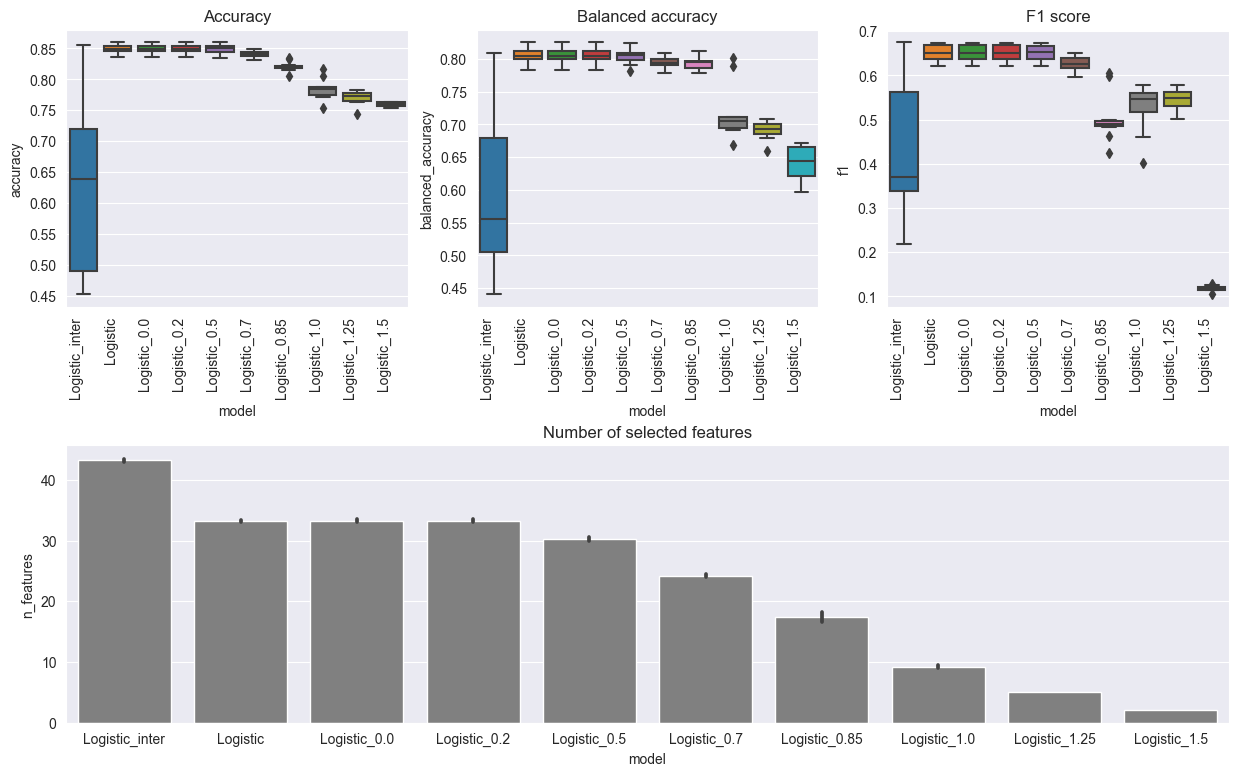

In [48]:
results_joined = pd.concat([results_inter, results_full, results_logistic_select])
results_logistic = results_joined[results_joined["model"].str.contains("Logistic")]

fig = plt.figure(figsize=(15, 9))

plt.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(2, 3, (4, 6))

sns.boxplot(results_logistic, x='model', y='accuracy', ax=ax1)
ax1.set_title("Accuracy")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')

sns.boxplot(results_logistic, x='model', y='balanced_accuracy', ax=ax2)
ax2.set_title("Balanced accuracy")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='right')

sns.boxplot(results_logistic, x='model', y='f1', ax=ax3)
ax3.set_title("F1 score")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, ha='right')

sns.barplot(results_logistic, x='model', y='n_features', color='gray', ax=ax4)
ax4.set_title("Number of selected features")

## Conclusions

* When all columns are considered, logistic regression is the best estimator among QDA, LDA and KNN.
* QDA performs poorly with colinear variables, feature selection improves the results.
* Logistic regression was the best estimator with feature selection.
* Model with interactions was very unstable. Numerical features had to be scaled, otherwise singular matrix was encountered during optimization. Even after scaling, the results have high variance.
* Removing correlated variables decreases performance of the model. However, models with about 20-30% original features still perform quite well.